# Data preprocessing and training

In [29]:
#Libraries

import numpy as np
import pandas as pd
import math
import os

import PIL
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa

from tensorflow.keras import callbacks
from tensorflow.keras.layers import *

import keras.backend as K

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow_addons.layers import GroupNormalization

import cv2 as cv

import segmentation_models as sm
from segmentation_models.base import functional as F
sm.set_framework('tf.keras')

physical_devices = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(physical_devices))

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('setted')
except:
    pass

tf.keras.backend.clear_session()

Num GPUs Available:  1
setted


In [45]:
#Globals

PATH_DIR = "../"
MASK_CLASS = ['large_bowel', 'small_bowel', 'stomach']
MASK_ENCODE = dict(zip(MASK_CLASS, np.arange(1,4)))

PIXEL_NORM = 65535

IMG_SIZE = (224, 224, 3)

MASK_COL = [np.array([255,0,0,120])/255. , np.array([0,0,255,120])/255., np.array([0,255,0,120])/255.]
MASK_COL_DICT = dict(zip(MASK_CLASS, MASK_COL))

# CLAHE = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [31]:
#Visualisation functions

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    img = img.reshape(shape)  # Needed to align to RLE direction
    
    return img

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def process_img(img_path, clahe=None, percentile=98):    
    """
    images are 16-bit png encoded. make sure you define the appropriate dtype when decoding
    there are light artifacts which impact the overall normalization.
    to reduce variance in training, we apply a CLAHE (contrast limited adaptive histogram equalization) to normalize the pixel intensities.
    """
    img = tf.io.decode_png(tf.io.read_file(img_path), dtype=tf.uint16)
    img = tf.cast(img, dtype=tf.float32)    
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))

    if clahe:
        img = tf.cast(img * 255, dtype=tf.uint8).numpy()
        return tf.expand_dims(tf.cast(clahe.apply(img)/255., dtype=tf.float32), axis=-1)
    
    else:
        return img

    return img

def plot_dataset(elem):
    """
    input is a (img, mask) tuple with a dimensions of (n, size, 1), (n, size, MASK_CLASS)
    batch size is usually a multiple of 2^N where N > 1, so they are divisible by 4
    """
    img, mask = elem
    batch_size = img.shape[0]
    
    num_cols = 4
    num_rows = batch_size // 4
    num_plots = num_cols * num_rows
    
    fig = plt.figure(figsize=(2*num_rows,8))
    plt.axis(False)

    for k in range(num_plots):
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(img[k,:,:])
        
        for i in range(len(MASK_CLASS)):
            ax.imshow(np.tile(mask[k,:,:,i][:,:,np.newaxis], 4) * MASK_COL[i])

        ax.axis(False)
        
    plt.tight_layout()
    plt.show()   
    return

def single_panel(df, caseid, day=None, slice_=0):
    
    _tmp_df = df[(df['caseid'] == caseid)]
    if day == None:
    #all days have 144 slices, so sample is aok
        day = _tmp_df['day'].sample().iloc[0]
        
    if isinstance(day, int):
        day = f'day{day}'
        
    _tmp_df = _tmp_df[_tmp_df['day'] == day]
    _tmp_df = _tmp_df[_tmp_df['slicenum'] == slice_].iloc[0]
    
    _img = process_img(_tmp_df['fn'])

    fig = plt.figure(figsize=(5,5))    
    ax = fig.add_subplot(111)
    ax = ax.hist(np.ravel(_img), bins=40)
    
    fig = plt.figure(figsize=(5,5))    
    ax = fig.add_subplot(111)
    ax.imshow(_img, cmap='gray')
    for class_ in MASK_CLASS:
        if not _tmp_df[class_] == 'nan':
            ax.imshow(np.tile(rle_decode(_tmp_df[class_], (_tmp_df['height'],_tmp_df['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
    ax.axis(False)
    ax.set_title(f'caseid{caseid}-{day}-{slice_}')
        
    plt.tight_layout()
    plt.show()
    
    return
    
def random_panels(df, caseid, day=None, start_slice=None):
    """
    will convert to rgb for plotting only - plot triplets of input
    """
    num_rows = 8
    num_cols = 8
    num_plots = num_rows * num_cols
    
    _tmp_df = df[(df['caseid'] == caseid)]
    
    if day == None:
        #all days have 144 slices, so sample is aok
        day = _tmp_df['day'].sample().iloc[0]
        
    if isinstance(day, int):
        day = f'day{day}'
        
    _tmp_df = _tmp_df[_tmp_df['day'] == day]
    max_slice = _tmp_df['total_slices'].iloc[0]
    
    if start_slice == None:
        start_slice = int((max_slice - num_plots) * np.random.rand())

    start_slice = min(start_slice, max_slice - num_plots)
    
    #create figure object, iterate over num_plots
    fig = plt.figure(figsize=(12,12))
    plt.title(f'caseid{caseid}-{day}-{start_slice}')
    plt.axis(False)
    
    for k in range(num_plots):
        _tmp_img = _tmp_df.iloc[start_slice + k]
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(process_img(_tmp_img['fn']), cmap='gray')
        for class_ in MASK_CLASS:
            if not _tmp_img[class_] == 'nan':
                ax.imshow(np.tile(rle_decode(_tmp_img[class_], (_tmp_img['height'],_tmp_img['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
        ax.axis(False)
        
    plt.tight_layout()
    plt.show()
    
    return

def random_panels_same_slice(df, start_slice=None):
    """
    will convert to rgb for plotting only - plot triplets of input
    """
    num_rows = 8
    num_cols = 8
    num_plots = num_rows * num_cols
    
    _tmp_df = df[df['slicenum'] == start_slice]
    idx_pos = int((len(_tmp_df) - num_plots) * np.random.rand())
    
    #create figure object, iterate over num_plots
    fig = plt.figure(figsize=(12,12))
    plt.title(f'{start_slice}')
    plt.axis(False)
    
    for k in range(num_plots):
        _tmp_img = _tmp_df.iloc[idx_pos + k]
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(process_img(_tmp_img['fn']), cmap='gray')
        for class_ in MASK_CLASS:
            if not _tmp_img[class_] == 'nan':
                ax.imshow(np.tile(rle_decode(_tmp_img[class_], (_tmp_img['height'],_tmp_img['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
        ax.axis(False)
        
    plt.tight_layout()
    plt.show()
    
    return


In [32]:
def df_preprocessing(df, train_glob, submission=False):
    """
    create processed dataframe from train.csv
    tf pipeline taking in to_dict does not like mixed classes inside columns. segmentation column contains NaN and strings, convert NaN to string
    
    sample_submission will be populated.
    """
    
    #use glob to get filepaths of images, and merge the paths into the original dataframe. isolate slice metadata into columns
    _glob_df = pd.DataFrame(train_glob, columns=['fn'])
    _glob_df['caseid'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[1].replace('case', '')))
    _glob_df['day'] = _glob_df['fn'].apply(lambda x: x.rsplit('/', 4)[2].split('_')[1])
    _glob_df['slicenum'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[1]))
    
    #WIDTH AND HEIGHT ARE MIXED UP.
    _glob_df['width'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[2]))
    _glob_df['height'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[3]))
    _glob_df['h_spacing'] = _glob_df['fn'].apply(lambda x: float(x.rsplit('/', 4)[-1].split('_')[4]))
    _glob_df['w_spacing'] = _glob_df['fn'].apply(lambda x: float(x.rsplit('/', 4)[-1].split('_')[5].rsplit('.',1)[0]))
    
    _glob_df['total_slices'] = _glob_df.groupby(['caseid', 'day'])['slicenum'].transform(len)
    
    if not submission:
        #unstack the class into columns. n_seg will let you know how many classes are present.
        df = df.fillna({'segmentation':'nan'})
        df = df.set_index(['id', 'class'])['segmentation'].unstack().reset_index()
        df['n_seg'] = (~(df.loc[:,['large_bowel', 'small_bowel', 'stomach']] == 'nan')).sum(axis=1)

        df['caseid'] = df['id'].apply(lambda x: int(x.split('_')[0].replace('case', '')))
        df['day'] = df['id'].apply(lambda x: x.split('_')[1])
        df['slicenum'] = df['id'].apply(lambda x: int(x.split('_')[-1]))

        df = df.merge(_glob_df, on=['caseid', 'day', 'slicenum'])

        #reorder
        column_order = ["id", "fn", "n_seg",
                        "large_bowel", "small_bowel", "stomach",
                        "height", "width", "h_spacing", 
                        "w_spacing", "caseid", "day", 
                        "total_slices", "slicenum",]
        
        #remove faulty cases
        df[~df['id'].str.contains('case7_day0') & ~df['id'].str.contains('case81_day30')].reset_index()
        
        return df[column_order]
    
    else:
        df = df.set_index(['id', 'class'])['predicted'].unstack().reset_index()
        df['caseid'] = df['id'].apply(lambda x: int(x.split('_')[0].replace('case', '')))
        df['day'] = df['id'].apply(lambda x: x.split('_')[1])
        df['slicenum'] = df['id'].apply(lambda x: int(x.split('_')[-1]))
    
        df = df.merge(_glob_df, on=['caseid', 'day', 'slicenum'])
        #reorder
        column_order = ["id", "fn", 
                        "height", "width", "h_spacing", 
                        "w_spacing", "caseid", "day", 
                        "total_slices", "slicenum",]
        return df[column_order]

train_df = pd.read_csv(f"{PATH_DIR}/train.csv")
train_fp = glob.glob(f'{PATH_DIR}/train/**/*.png', recursive=True)

train_df = df_preprocessing(train_df, train_fp)

train_df.head()

id  \
0  case101_day20_slice_0001   
1  case101_day20_slice_0002   
2  case101_day20_slice_0003   
3  case101_day20_slice_0004   
4  case101_day20_slice_0005   

                                                  fn  n_seg large_bowel  \
0  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
1  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
2  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
3  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
4  ..//train/case101/case101_day20/scans/slice_00...      0         nan   

  small_bowel stomach  height  width  h_spacing  w_spacing  caseid    day  \
0         nan     nan     266    266        1.5        1.5     101  day20   
1         nan     nan     266    266        1.5        1.5     101  day20   
2         nan     nan     266    266        1.5        1.5     101  day20   
3         nan     nan     266    266        1.5        1.5     101  day20   
4         nan     nan     266    266        1.5        1.5     101  day20   

   total_slices  slicenum  
0           144         1  
1           144         2  
2           144         3  
3           144         4  
4           144         5

In [33]:
#convert preprocessing df into 2.5D by including filenames for strided patches.

def add_stride(row, shift):
    """
    takes in the row, finds the filename for the current_slice + strided patch.
    clip by maximum number of slices
    """
    cur_slice = row['slicenum']
    fn_1, fn_2 = row['fn'].split(f"{cur_slice:04.0f}")
    
    next_slice = np.clip(cur_slice + shift, None, row['total_slices'])
    
    return fn_1 + f'{next_slice:04.0f}' + fn_2  

def df_strided(df, stride=2, submission=False):
    """
    add strided columns into df
    """   
    if len(df['fn']) < 1:
        df['fn_1'] = ""
        df['fn_2'] = ""
        
    else:
        df['fn_1'] = df.apply(lambda row: add_stride(row, stride), axis=1)
        df['fn_2'] = df.apply(lambda row: add_stride(row, stride*2), axis=1)
    
    if not submission:
        column_order = ["id", "fn", "fn_1", "fn_2", "n_seg",
                    "large_bowel", "small_bowel", "stomach",
                    "height", "width", "h_spacing", 
                    "w_spacing", "caseid", "day", 
                    "total_slices", "slicenum",]

    else:
        column_order = ["id", "fn", "fn_1", "fn_2", 
                "height", "width", "h_spacing", 
                "w_spacing", "caseid", "day", 
                "total_slices", "slicenum",]
        
    return df[column_order]

train_df = df_strided(train_df)

train_df.head()


id  \
0  case101_day20_slice_0001   
1  case101_day20_slice_0002   
2  case101_day20_slice_0003   
3  case101_day20_slice_0004   
4  case101_day20_slice_0005   

                                                  fn  \
0  ..//train/case101/case101_day20/scans/slice_00...   
1  ..//train/case101/case101_day20/scans/slice_00...   
2  ..//train/case101/case101_day20/scans/slice_00...   
3  ..//train/case101/case101_day20/scans/slice_00...   
4  ..//train/case101/case101_day20/scans/slice_00...   

                                                fn_1  \
0  ..//train/case101/case101_day20/scans/slice_00...   
1  ..//train/case101/case101_day20/scans/slice_00...   
2  ..//train/case101/case101_day20/scans/slice_00...   
3  ..//train/case101/case101_day20/scans/slice_00...   
4  ..//train/case101/case101_day20/scans/slice_00...   

                                                fn_2  n_seg large_bowel  \
0  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
1  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
2  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
3  ..//train/case101/case101_day20/scans/slice_00...      0         nan   
4  ..//train/case101/case101_day20/scans/slice_00...      0         nan   

  small_bowel stomach  height  width  h_spacing  w_spacing  caseid    day  \
0         nan     nan     266    266        1.5        1.5     101  day20   
1         nan     nan     266    266        1.5        1.5     101  day20   
2         nan     nan     266    266        1.5        1.5     101  day20   
3         nan     nan     266    266        1.5        1.5     101  day20   
4         nan     nan     266    266        1.5        1.5     101  day20   

   total_slices  slicenum  
0           144         1  
1           144         2  
2           144         3  
3           144         4  
4           144         5

In [34]:
"""
Augmentations

After some EDA, the position of the bodies on the image can be translated and possibily rotated up to a few degrees.
Color contrast could be minorly adjusted, maybe by changing the percentile pixel from 98% to 97-99%
Finally, small zooms could be implemented.

MRI's feet first-head first or both? This will tell us if we need to apply left/right flips.

THESE AUGMENTATIONS SHOULD BE APPLIED IN A (1,x,y,SET)


Train first without any augmentation, then add augmentation later
"""

def norm_color(images, labels):
    
    img_cutoff = tfp.stats.percentile(images, 98)
    
    img = tf.math.divide_no_nan(images, img_cutoff)
    img = tf.clip_by_value(img, 0., 1.)
    
    return img, labels

def resnet_preprocess(images, labels):
    
    img = tf.clip_by_value(images, 0., 1.)
    img *= 255.
    
    return tf.keras.applications.resnet_v2.preprocess_input(img), labels

def fixup_shape(images, labels):
    """
    fixes shape to be via crop/pad 272 x 272, use as final
    """
    height = IMG_SIZE[0]
    width = IMG_SIZE[1]
    
    return tf.image.resize_with_pad(images, height, width, method='bilinear'), tf.image.resize_with_pad(labels, height, width, method='nearest')
    
def random_zoom(img, label, p=0.75):
    """
    random zoom between -10% -> 10%. to achieve this, 
    then apply a standard resize to IMG_SIZE using bilinear + nearest neighbour interpolation.
    preserve aspect ratio
    """
    if tf.random.uniform([]) > p: return img, label
    
    w = img.shape[1]
    w = tf.cast(w * tf.random.uniform([], 0.90, 1.1), dtype=tf.int32)
    
    return tf.image.resize_with_pad(img, w, w, method='bilinear'), tf.image.resize_with_pad(label, w, w, method='nearest')

def random_rotate(img, label, p=0.75):
    """
    -15 -> 15 degrees (0 - pi/12 degrees)
    """
    if tf.random.uniform([]) > p: return img, label
    
    angle = tf.random.uniform([], -np.pi/18, np.pi/18)
    
    return tfa.image.rotate(img, angle), tfa.image.rotate(label, angle)

def random_shift(img, label, p=0.75):
    """
    random translation of image, towards the center (more black pixels).
    """
    
    if tf.random.uniform([]) > p: return img, label
    
    thresh = 0.1
    h, w = img.shape[0], img.shape[1]
    div = 3
    
    top_row = tf.math.reduce_sum(tf.cast(img[:h//div,:,0] < 0.1, dtype=tf.float32))
    bottom_row = tf.math.reduce_sum(tf.cast(img[-h//div:,:,0] < 0.1, dtype=tf.float32))
    
    left_col = tf.math.reduce_sum(tf.cast(img[:,:w//div,0] < 0.1, dtype=tf.float32))
    right_col = tf.math.reduce_sum(tf.cast(img[:,-w//div:,0] < 0.1, dtype=tf.float32))
    
    if top_row/bottom_row > 1 - thresh and top_row/bottom_row < 1 + thresh:
        y_dir = 0
    elif top_row/bottom_row < 1 - thresh:
        y_dir = 1
    else:
        y_dir = -1
        
    if left_col/right_col > 1 - thresh and left_col/right_col < 1 + thresh:
        x_dir = 0
    elif left_col/right_col < 1 - thresh:
        x_dir = 1
    else:
        x_dir = -1

    h = tf.cast(y_dir * h * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
    w = tf.cast(x_dir * w * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
        
    return tfa.image.translate(img, [w, h]), tfa.image.translate(label, [w, h])

def random_colour(img, label, p=0.65):
    """
    randomizes contrast by selecting percentile pixel to take as brightest
    
    INCLUDED IN THE CONSTRUCT DATABASE FUNCTION
    """
    if tf.random.uniform([]) > p: return img, label
    
    sat = [0.8, 1.2]  # saturation
    cont = [0.9, 1.1]  # contrast
    bri = 0.10  # brightness
    hue = 0.0  # hue
    
    img = tf.image.random_hue(img, hue)
    img = tf.image.random_saturation(img, sat[0], sat[1])
    img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)
    
    return img, label

def random_flip(img, label, p=0.5):
    """
    optional. i believe people enter MRI's the same way?
    """
    if tf.random.uniform([]) > p: return img, label
    
    return tf.image.flip_left_right(img), tf.image.flip_left_right(label)


def CutOut(image, mask=None, DIM=IMG_SIZE[:2], PROBABILITY=0.5, CT=10, SZ=0.075):
    """
    shamelessly stolen from a notebook, see if this improves
    ref: https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    """
    # Input Image - is with shape [dim,dim,3] not of [None,dim,dim,3]
    # Probability
    P = tf.cast(tf.random.uniform([]) < PROBABILITY, tf.int32)
    if (P == 0) | (CT == 0) | (SZ == 0):
        return image, mask
    # Iterate Through Each Sample of Batch
    for k in range(CT):
        # Choose Random Location
        x = tf.cast(tf.random.uniform([], 0, DIM[1]), tf.int32)
        y = tf.cast(tf.random.uniform([], 0, DIM[0]), tf.int32)
        # Compute Square for CutOut
        WIDTH = tf.cast(SZ * min(DIM), tf.int32) * P
        ya = tf.math.maximum(0, y - WIDTH // 2)
        yb = tf.math.minimum(DIM[0], y + WIDTH // 2)
        xa = tf.math.maximum(0, x - WIDTH // 2)
        xb = tf.math.minimum(DIM[1], x + WIDTH // 2)
        # CutOut Image
        one = image[ya:yb, 0:xa, :]
        two = tf.zeros([yb - ya, xb - xa, 3], dtype=image.dtype)
        three = image[ya:yb, xb : DIM[1], :]
        middle = tf.concat([one, two, three], axis=1)
        image = tf.concat([image[0:ya, :, :], middle, image[yb : DIM[0], :, :]], axis=0)
        image = tf.reshape(image, [*DIM, 3])
        # CutOut Mask
        if mask is not None:
            one = mask[ya:yb, 0:xa, :]
            two = tf.zeros([yb - ya, xb - xa, 3], dtype=mask.dtype)  # ch=3
            three = mask[ya:yb, xb : DIM[1], :]
            middle = tf.concat([one, two, three], axis=1)
            mask = tf.concat(
                [mask[0:ya, :, :], middle, mask[yb : DIM[0], :, :]], axis=0
            )
            mask = tf.reshape(mask, [*DIM, 3])  # ch=3
    return image, mask



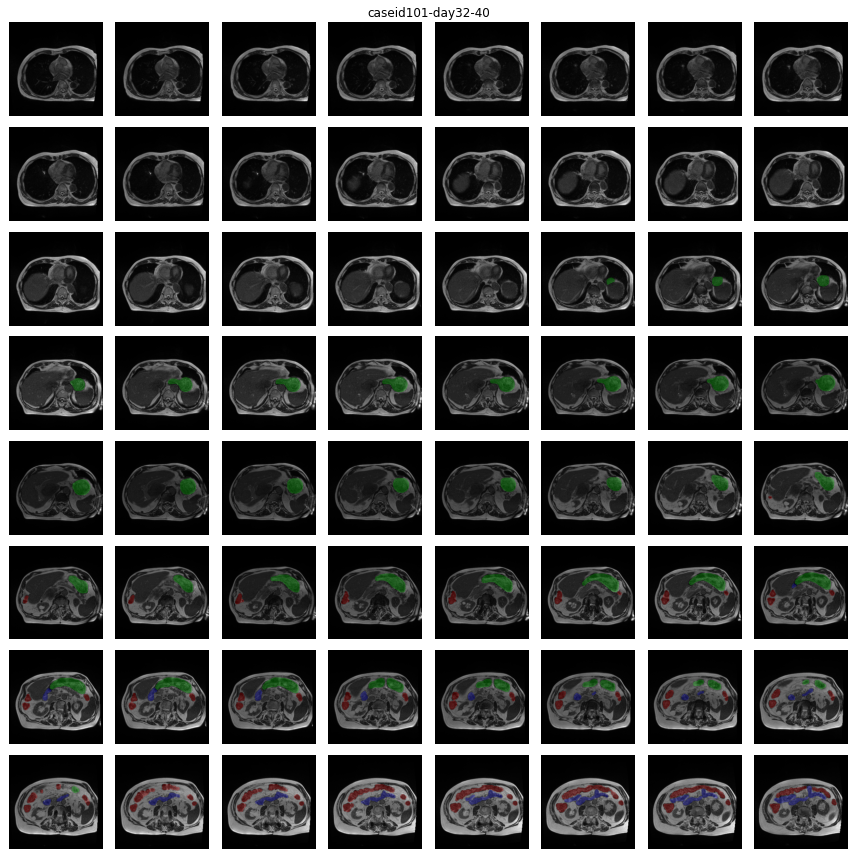

In [35]:
TEST_CASE_ID = 101
TEST_START_SLICE = 40
TEST_DAY = None

random_panels(train_df, TEST_CASE_ID, day=TEST_DAY, start_slice=TEST_START_SLICE)

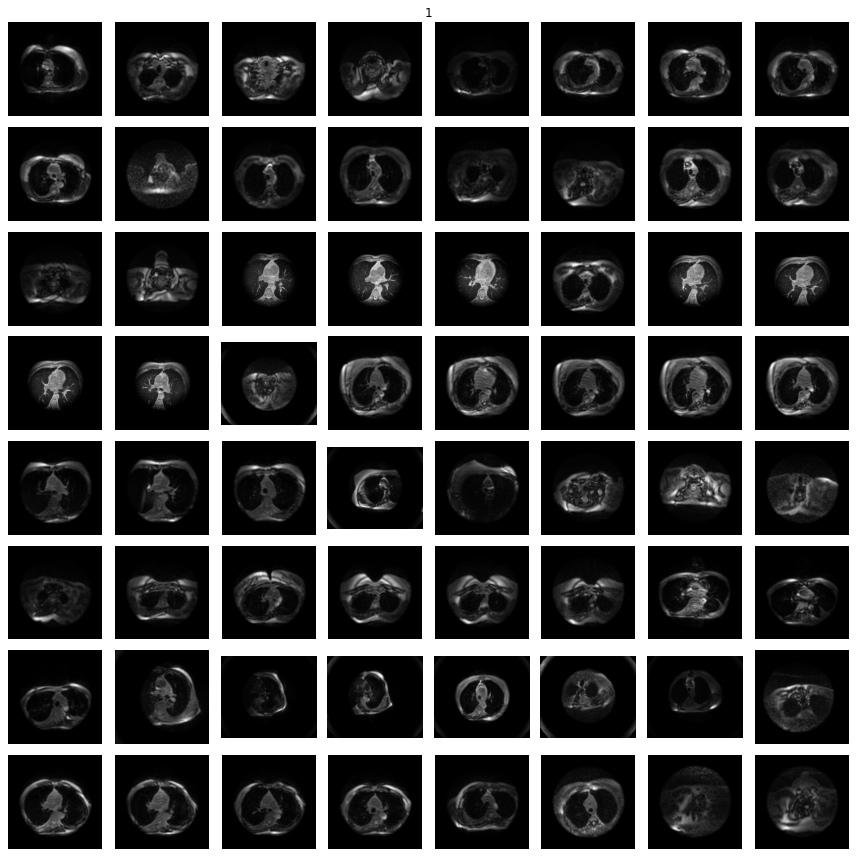

In [36]:
random_panels_same_slice(train_df, start_slice=1)

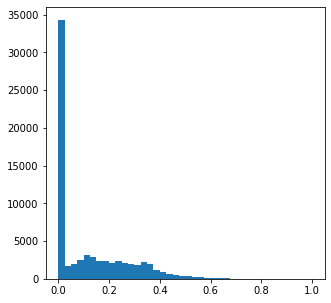

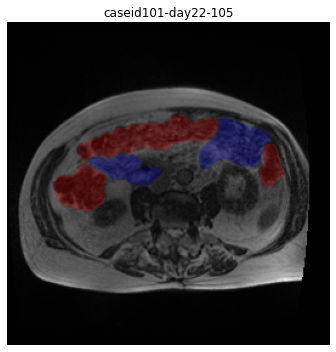

In [9]:
single_panel(train_df, TEST_CASE_ID, 22, 105)

In [10]:
"""
Data pipeline
"""
def dict_py_function(func, inp, Tout):
    """
    Trick py_function to take in a dict by passing our input off as an array, then reconstructing it inside a wrapped function
    Completely dumb.
    """
    def wrapped_func(*flattened_inp):
        #To reconstruct, pass tf.nest.pack_sequence_as(dict, flattened_dict_of_values, expand_composites=True)
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flattened_inp, expand_composites=True)
        return func(*reconstructed_inp)
        
    return tf.py_function(func=wrapped_func, inp=tf.nest.flatten(inp, expand_composites=True), Tout=Tout)

def df_parser(row):
    """
    want to read file, process it, produce mask in multi-hot encoding
    img/mask output would be (size, 1)
    process image only once, include random_contrast here
    """
    CLAHE = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    img = np.empty((row['height'].numpy(), row['width'].numpy(), 3))
    
    img[...,0] = tf.squeeze(process_img(row['fn'], clahe=CLAHE))
    img[...,1] = tf.squeeze(process_img(row['fn_1'], clahe=CLAHE))
    img[...,2] = tf.squeeze(process_img(row['fn_2'], clahe=CLAHE))
    
    mask = tf.zeros_like(img[...,0], dtype=tf.uint8)
    mask = tf.one_hot(tf.squeeze(mask), len(MASK_CLASS) + 1)
    mask_total = mask

    if row['n_seg'] == 0:
        return img, mask_total[...,1:]
    else:
        for class_ in MASK_CLASS:
            if row[class_] == 'nan':
                mask_total += mask
            else:
                mask_total += tf.one_hot(tf.constant(rle_decode(row[class_].numpy(), (row['height'], row['width'])) * MASK_ENCODE[class_], dtype=tf.uint8), len(MASK_CLASS) + 1)

        #this is sigmoid, no need a background class.
        mask_total = tf.cast(mask_total[...,1:], dtype=tf.float32)
                                         
        return img, mask_total
    
def construct_dataset(df):
    """
    split before construction. ensures reproducibility
    """
    train_dataset  = tf.data.Dataset.from_tensor_slices(df.to_dict('list')) 
    train_len = train_dataset.cardinality().numpy()
    
    print(f"-- dataset sizes -- train:{train_len}")
                                     
    return train_dataset, train_len

In [11]:
#stratifiedgroupkfold. by n_seg, but grouped by case_id (i.e, preserve case_id to prevent data leakage)

kfold = StratifiedGroupKFold(5, shuffle=True, random_state=42)
split = kfold.split(train_df, train_df['n_seg'], groups=train_df['caseid'])

for i, (_, te) in enumerate(kfold.split(train_df, train_df['n_seg'], groups=train_df['caseid'])):
    train_df.loc[te, 'fold'] = i

print(train_df.head())
print(train_df.groupby(['fold', 'n_seg'])['id'].count())

                         id  \
0  case101_day20_slice_0001   
1  case101_day20_slice_0002   
2  case101_day20_slice_0003   
3  case101_day20_slice_0004   
4  case101_day20_slice_0005   

                                                  fn  \
0  ..//train/case101/case101_day20/scans/slice_00...   
1  ..//train/case101/case101_day20/scans/slice_00...   
2  ..//train/case101/case101_day20/scans/slice_00...   
3  ..//train/case101/case101_day20/scans/slice_00...   
4  ..//train/case101/case101_day20/scans/slice_00...   

                                                fn_1  \
0  ..//train/case101/case101_day20/scans/slice_00...   
1  ..//train/case101/case101_day20/scans/slice_00...   
2  ..//train/case101/case101_day20/scans/slice_00...   
3  ..//train/case101/case101_day20/scans/slice_00...   
4  ..//train/case101/case101_day20/scans/slice_00...   

                                                fn_2  n_seg large_bowel  \
0  ..//train/case101/case101_day20/scans/slice_00...      0     

In [12]:
#check that caseids in our fold is not also found in the set outside of our fold

np.isin(train_df[train_df['fold'] == 1]['caseid'].unique(), train_df[~(train_df['fold'] == 1)]['caseid'].unique())

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [13]:
#MultiResidualUNet
#https://arxiv.org/abs/1902.04049

#Randomly initialized weights

"""
def conv_block(input_tensor, n_filters, kernel_size, strides=(1,1), activation='relu', padding='same', kernel_initializer="he_normal"):
    x = Conv2D(n_filters, kernel_size, strides=strides, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(input_tensor)
    x = BatchNormalization()(x)
    return x

def MultiResBlock(n_filters, input_tensor, alpha = 1.67, dropout=None):
    W = alpha * n_filters
    
    shortcut = input_tensor
    shortcut = conv_block(shortcut, int(W*0.167) + int(W*0.333) +
                          int(W*0.5), (1, 1), activation=None, padding='same')

    conv3x3 = conv_block(input_tensor, int(W*0.167), (3, 3),
                         activation='relu', padding='same')

    conv5x5 = conv_block(conv3x3, int(W*0.333), (3, 3),
                         activation='relu', padding='same')

    conv7x7 = conv_block(conv5x5, int(W*0.5), (3, 3),
                         activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    if dropout: out = Dropout(dropout)(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(n_filters, length, input_tensor):
    shortcut = input_tensor
    shortcut = conv_block(shortcut, n_filters, (1, 1),
                         activation=None, padding='same')

    out = conv_block(input_tensor, n_filters, (3, 3), activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv_block(shortcut, n_filters, (1, 1),
                              activation=None, padding='same')

        out = conv_block(out, n_filters, (3, 3), activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

def Reslayer_down(input_tensor, n_filters, length, dropout=None):
    conv = MultiResBlock(n_filters, input_tensor, dropout=None)
    pool = MaxPooling2D((2,2))(conv)
    if dropout: pool = Dropout(dropout)(pool)
    conv = ResPath(n_filters, length, input_tensor)

    return conv, pool

def Reslayer_up(input_tensor, concat_tensor, n_filters, dropout=None):
    decv = concatenate([Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor), concat_tensor])
    decv = MultiResBlock(n_filters, decv, dropout=dropout)

    return decv


def mRES_net(input_size=(128,128,3), n_output=1, n_base=24, dropout=None, pretrained_weights=None):
    img_input = Input(input_size)

    c1, d1 = Reslayer_down(img_input, n_base, 5)
    c2, d2 = Reslayer_down(d1, n_base*2,  4, dropout=dropout)
    c3, d3 = Reslayer_down(d2, n_base*4,  3)
    c4, d4 = Reslayer_down(d3, n_base*8,  2, dropout=dropout)
    c5, d5 = Reslayer_down(d4, n_base*16, 1)

    c6 = MultiResBlock(n_base*32, d5)

    u5 = Reslayer_up(c6, c5, n_base*16)
    u4 = Reslayer_up(u5, c4, n_base*8, dropout=dropout)
    u3 = Reslayer_up(u4, c3, n_base*4)
    u2 = Reslayer_up(u3, c2, n_base*2, dropout=dropout)
    u1 = Reslayer_up(u2, c1, n_base)

    out = Conv2D(n_output, (1, 1) , padding='same',activation='sigmoid')(u1)

    model = tf.keras.Model(inputs=[img_input], outputs=[out])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
"""

""

''

In [14]:
#UNet with a pretrained ResNetv2 backbone with Imagenet weights
#Additional convolutional blocks in skip connection to "match the level of processing" as the features progagate along the network
#As suggested by MResUNet article

def conv_block(input_tensor, n_filters, kernel_size=(3,3), strides=(1,1), activation=tfa.activations.gelu, padding='same', kernel_initializer="he_normal", norm='group'):
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(input_tensor)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def res_path(n_filters, length, input_tensor, norm='group'):
    shortcut = input_tensor
    shortcut = conv_block(shortcut, n_filters, (1, 1),
                         activation=None, padding='same')

    out = conv_block(input_tensor, n_filters, (3, 3), activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    if norm:
        out = GroupNormalization()(out)
    else:
        out = BatchNormalization()(out)
    
    for i in range(length-1):
        shortcut = out
        shortcut = conv_block(shortcut, n_filters, (1, 1),
                              activation=None, padding='same')

        out = conv_block(out, n_filters, (3, 3), activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        if norm:
            out = GroupNormalization()(out)
        else:
            out = BatchNormalization()(out)

    return out

def decoder_block(input_tensor, skip, n_filters, activation=tfa.activations.gelu, upsample='transpose', norm='group'):
    if upsample == 'transpose':
        x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    else:
        x = UpSampling2D(size=2, interpolation='bilinear')(input_tensor)
    
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Concatenate()([x, skip])

    x = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x

def res_unet(input_size, n_output=3, n_filter=64, enc_freeze=False, respath=False):
    
    img_input = Input(input_size)
    
    encoder = ResNet50V2(include_top=False, weights='imagenet', input_tensor=img_input)
    
    #skip connections
    s1 = encoder.get_layer(index=0).output ##128
    s2 = encoder.get_layer(index=2).output ##64, 64
    s3 = encoder.get_layer(index=32).output ##32, 64
    s4 = encoder.get_layer(index=78).output ##16, 128
    
    if respath:
        s1 = res_path(32, 4, s1)
        s2 = res_path(n_filter, 3, s2)
        s3 = res_path(n_filter, 2, s3)
        s4 = res_path(n_filter*2, 1, s4)
        
    #bridge
    b1 = encoder.get_layer(index=146).output ##8, 256
    
    if enc_freeze:
        encoder.trainable = False
    
    #decoder
    d4 = decoder_block(b1, s4, n_filter*8)
    d3 = decoder_block(d4, s3, n_filter*4)
    d2 = decoder_block(d3, s2, n_filter*2)
    d1 = decoder_block(d2, s1, n_filter)
    
    out = Conv2D(n_output, (1, 1) , padding='same', activation='sigmoid')(d1)
    
    model = tf.keras.Model(img_input, out, name='res50v2unet')
    
    return model



In [15]:
#Blank MCG Unet with Resnet backbone initialized with Imagenet weights.
#https://arxiv.org/abs/1909.00166

"""
def conv_block(input_tensor, n_filters, kernel_size=(3,3), strides=(1,1), activation=tfa.activations.gelu, padding='same', kernel_initializer="he_normal", norm='group'):
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(input_tensor)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def res_path(n_filters, length, input_tensor, norm='group'):
    shortcut = input_tensor
    shortcut = conv_block(shortcut, n_filters, (1, 1),
                         activation=None, padding='same')

    out = conv_block(input_tensor, n_filters, (3, 3), activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    if norm:
        out = GroupNormalization()(out)
    else:
        out = BatchNormalization()(out)
    
    for i in range(length-1):
        shortcut = out
        shortcut = conv_block(shortcut, n_filters, (1, 1),
                              activation=None, padding='same')

        out = conv_block(out, n_filters, (3, 3), activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        if norm:
            out = GroupNormalization()(out)
        else:
            out = BatchNormalization()(out)

    return out


def squeeze_excite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]

    y = GlobalAveragePooling2D()(x)
    y = Dense(nb_chan // ratio, activation='relu')(y)
    y = Dense(nb_chan, activation='sigmoid')(y)

    y = Multiply()([x, y])
    return y


def decoder_block(input_tensor, skip, n_filters, n, activation=tfa.activations.gelu, norm='group'):

    x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    x = squeeze_excite(x)
    
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
        
    x = Activation(activation)(x)
    
    x1 = Reshape(target_shape=(1, np.int32(n), np.int32(n), n_filters))(skip)
    x2 = Reshape(target_shape=(1, np.int32(n), np.int32(n), n_filters))(x)
    
    merge  = concatenate([x1,x2], axis = 1) 
    merge = ConvLSTM2D(filters = n_filters, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge)
    
    x = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x)

    x = squeeze_excite(x, ratio=16) 

    return x

def decoder_block_classic(input_tensor, skip, n_filters, activation=tfa.activations.gelu, upsample='transpose', norm='group'):
    if upsample == 'transpose':
        x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    else:
        x = UpSampling2D(size=2, interpolation='bilinear')(input_tensor)
    
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Concatenate()([x, skip])

    x = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x

def dense_block(input_tensor, n_filters, activation=tfa.activations.gelu, dropout=0.5):
    
    x1 = Conv2D(n_filters, (3, 3), activation=activation, padding='same')(input_tensor)
    # D2
    x2 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x1)     
    x2 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x2)
    x2 = Dropout(dropout)(x2)
    # D3
    merge = concatenate([x2, x1], axis = 3)
    
    x3 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(merge)     
    x3 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x3)
    x3 = Dropout(dropout)(x3)
    
    return x3

    
def mcg_unet(input_size, n_output=3, n_filter=64, enc_freeze=False, load_weights=False):
    img_input = Input(input_size)
    N = input_size[0]
    
    encoder = ResNet50V2(include_top=False, weights='imagenet', input_tensor=img_input)
    
    #skip connections
    s1 = encoder.get_layer(index=0).output ##128
    s2 = encoder.get_layer(index=2).output ##64, 64
    s3 = encoder.get_layer(index=32).output ##32, 64
    s4 = encoder.get_layer(index=78).output ##16, 128
    
    s1 = res_path(32, 4, s1)
    
    #bridge
    b1 = encoder.get_layer(index=146).output ##8, 256
    
    if enc_freeze:
        encoder.trainable = False
        
    b1 = dense_block(b1, n_filter*4)
    
    #decoder
    d4 = decoder_block(b1, s4, n_filter*2, N/8)
    d3 = decoder_block(d4, s3, n_filter*1, N/4)
    d2 = decoder_block(d3, s2, n_filter*1, N/2)
    d1 = decoder_block_classic(d2, s1, n_filter)
    
    out = Conv2D(n_output, (1, 1) , padding='same', activation='sigmoid')(d1)
    
    model = tf.keras.Model(img_input, out, name='mcg_unet')
    
    return model
"""

""

''

In [16]:
#MCGUNet, using encoder weights taken from our best performing ResUNet model.
#Initialize our best performing model and set weights on the corresponding layers.
"""
def conv_block(input_tensor, n_filters, kernel_size=(3,3), strides=(1,1), activation=tfa.activations.gelu, padding='same', kernel_initializer="he_normal", norm='group'):
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(input_tensor)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(n_filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def res_path(n_filters, length, input_tensor, norm='group'):
    shortcut = input_tensor
    shortcut = conv_block(shortcut, n_filters, (1, 1),
                         activation=None, padding='same')

    out = conv_block(input_tensor, n_filters, (3, 3), activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    if norm:
        out = GroupNormalization()(out)
    else:
        out = BatchNormalization()(out)
    
    for i in range(length-1):
        shortcut = out
        shortcut = conv_block(shortcut, n_filters, (1, 1),
                              activation=None, padding='same')

        out = conv_block(out, n_filters, (3, 3), activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        if norm:
            out = GroupNormalization()(out)
        else:
            out = BatchNormalization()(out)

    return out


def squeeze_excite(x, ratio=16):
    nb_chan = K.int_shape(x)[-1]

    y = GlobalAveragePooling2D()(x)
    y = Dense(nb_chan // ratio, activation='relu')(y)
    y = Dense(nb_chan, activation='sigmoid')(y)

    y = Multiply()([x, y])
    return y


def decoder_block(input_tensor, skip, n_filters, n, activation=tfa.activations.gelu, norm='group'):

    x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    x = squeeze_excite(x)
    
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
        
    x = Activation(activation)(x)
    
    x1 = Reshape(target_shape=(1, np.int32(n), np.int32(n), n_filters))(skip)
    x2 = Reshape(target_shape=(1, np.int32(n), np.int32(n), n_filters))(x)
    
    merge  = concatenate([x1,x2], axis = 1) 
    merge = ConvLSTM2D(filters = n_filters, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge)
    
    x = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x)

    x = squeeze_excite(x, ratio=16) 

    return x

def decoder_block_classic(input_tensor, skip, n_filters, activation=tfa.activations.gelu, upsample='transpose', norm='group'):
    if upsample == 'transpose':
        x = Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
    else:
        x = UpSampling2D(size=2, interpolation='bilinear')(input_tensor)
    
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Concatenate()([x, skip])

    x = Conv2D(n_filters, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    if norm:
        x = GroupNormalization()(x)
    else:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x

def dense_block(input_tensor, n_filters, activation=tfa.activations.gelu, dropout=0.5):
    
    x1 = Conv2D(n_filters, (3, 3), activation=activation, padding='same')(input_tensor)
    # D2
    x2 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x1)     
    x2 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x2)
    x2 = Dropout(dropout)(x2)
    # D3
    merge = concatenate([x2, x1], axis = 3)
    
    x3 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(merge)     
    x3 = Conv2D(n_filters, 3, activation = activation, padding = 'same', kernel_initializer = 'he_normal')(x3)
    x3 = Dropout(dropout)(x3)
    
    return x3

    
def mcg_unet(input_size, n_output=3, n_filter=64, enc_freeze=False):
    img_input = Input(input_size)
    N = input_size[0]
    
    old_model = tf.keras.models.load_model(f'models/model_2.5resnet_224_respath_clahe_adam_1.hdf5', compile=False)
    old_names = [i.name for i in old_model.layers]
    
    encoder = ResNet50V2(include_top=False, weights='imagenet', input_tensor=img_input)
    
    for layer in encoder.layers:
        if layer.name in old_names:
            layer.set_weights(old_model.get_layer(layer.name).get_weights())
    
    #skip connections
    s1 = encoder.get_layer(index=0).output ##128
    s2 = encoder.get_layer(index=2).output ##64, 64
    s3 = encoder.get_layer(index=32).output ##32, 64
    s4 = encoder.get_layer(index=78).output ##16, 128
    
    s1 = res_path(32, 4, s1)
    
    #bridge
    b1 = encoder.get_layer(index=146).output ##8, 256
    
    if enc_freeze:
        encoder.trainable = False
        
    b1 = dense_block(b1, n_filter*4)
    
    #decoder
    d4 = decoder_block(b1, s4, n_filter*2, N/8)
    d3 = decoder_block(d4, s3, n_filter*1, N/4)
    d2 = decoder_block(d3, s2, n_filter*1, N/2)
    d1 = decoder_block_classic(d2, s1, n_filter)
    
    out = Conv2D(n_output, (1, 1) , padding='same', activation='sigmoid')(d1)
    
    model = tf.keras.Model(img_input, out, name='mcg_encoder_weights')
    
    return model
"""

""

''

In [17]:
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
    

In [18]:
kwargs = {}
kwargs["backend"] = K

def weighted_cce(y_true, y_pred):
    weights = np.array([1,1,1])

    weights = weights.reshape((1,1,1,3))
    kWeights = K.constant(weights)

    yWeights = kWeights * y_true         #shape (batch, n, m, class_labels)
    yWeights = K.sum(yWeights, axis=-1)  #shape (batch, n, m), each pixel is 'weighed' if they match

    loss = K.categorical_crossentropy(y_true, y_pred) #shape (batch, n, m), unweighed cc at each pixel
    wLoss = yWeights * loss

    return wLoss


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice

In [19]:
#AdamW needs a slight modification to exclude the weight decay of the BN layers. 

def dice_cce(y_true, y_pred):   
    return 0.5*tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5*sm.losses.dice_loss(y_true, y_pred)

new_namespace = {
    'dice_coef': dice_coef,
    'f1-score': sm.metrics.FScore,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}

tf.keras.utils.get_custom_objects().update(new_namespace)

opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
#opt = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5, clipvalue=700, epsilon=1.0)
#opt = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

model = res_unet(IMG_SIZE, n_output=3, n_filter=64, enc_freeze=False, respath=True)

model.compile(loss=dice_cce, optimizer=opt, metrics=[dice_coef,'precision', 'recall', 'f1-score'])

model.summary()

Model: "res50v2unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 activation_2 (Activation)      (None, 224, 224, 32  0           ['group_normalization_2[0][0]']  
                                )                                                                 
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 group_normalization_20 (GroupN  (None, 112, 112, 64  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_22 (GroupN  (None, 112, 112, 64  128        ['conv2d_18[0][0]']              
 ormalizat

                                                                                                  
 group_normalization_47 (GroupN  (None, 28, 28, 128)  256        ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_29 (Conv2D)             (None, 56, 56, 64)   4160        ['activation_35[0][0]']          
                                                                                                  
 conv2d_31 (Conv2D)             (None, 56, 56, 64)   36928       ['activation_37[0][0]']          
                                                                                                  
 activation_21 (Activation)     (None, 112, 112, 64  0           ['group_normalization_21[0][0]'] 
                                )                                                                 
          

                                                                                                  
 activation_39 (Activation)     (None, 56, 56, 64)   0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 64  4160        ['group_normalization_24[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 112, 112, 64  36928       ['group_normalization_24[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_5 (Activation)      (None, 224, 224, 32  0           ['group_normalization_5[0][0]']  
          

 activation_40 (Activation)     (None, 56, 56, 64)   0           ['group_normalization_40[0][0]'] 
                                                                                                  
 activation_42 (Activation)     (None, 56, 56, 64)   0           ['group_normalization_42[0][0]'] 
                                                                                                  
 group_normalization_26 (GroupN  (None, 112, 112, 64  128        ['conv2d_21[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_28 (GroupN  (None, 112, 112, 64  128        ['conv2d_23[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 add_1 (Ad

                                                                                                  
 activation_10 (Activation)     (None, 224, 224, 32  0           ['group_normalization_10[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_12 (Activation)     (None, 224, 224, 32  0           ['group_normalization_12[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_52 (Activation)     (None, 56, 56, 256)  0           ['group_normalization_52[0][0]'] 
                                                                                                  
 group_normalization_44 (GroupN  (None, 56, 56, 64)  128         ['activation_44[0][0]']          
 ormalizat

 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_54 (GroupN  (None, 112, 112, 12  256        ['conv2d_transpose_2[0][0]']     
 ormalization)                  8)                                                                
                                                                                                  
 activation_34 (Activation)     (None, 112, 112, 64  0           ['add_6[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  1056        ['group_normalization_14[0][0]'] 
                                )                                                                 
          

 conv2d_43 (Conv2D)             (None, 224, 224, 64  55360       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 group_normalization_57 (GroupN  (None, 224, 224, 64  128        ['conv2d_43[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_57 (Activation)     (None, 224, 224, 64  0           ['group_normalization_57[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 224, 224, 3)  195         ['activation_57[0][0]']          
          

In [20]:
print(len(train_df))
print(len(train_df[~(train_df['fold'].isin([0,1,2]))]))
print(len(train_df[(train_df['fold'].isin([0,1]))]))
print(len(train_df[(train_df['fold'].isin([2]))]))

38496
16000
14544
7952


In [25]:
"""
cleanest order should be, shift, zoom, rotate, fix
CutOut to be applied after fixup
dont forget to preprocess the image [-1,1] for the input for the resnet backbone
"""

train_ds, train_len = construct_dataset(train_df[~(train_df['fold'].isin([1]))])
val_ds, val_len = construct_dataset(train_df[(train_df['fold'].isin([1]))])

EPOCHS = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = train_len // BATCH_SIZE

train_ds = train_ds.shuffle(4096) \
                   .map(lambda a: dict_py_function(df_parser, [a], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .map(random_colour) \
                   .map(random_flip) \
                   .map(lambda x1, y1: tf.py_function(random_shift, [x1, y1, 0.75], [tf.float32, tf.float32])) \
                   .map(lambda x2, y2: tf.py_function(random_zoom, [x2, y2, 0.75], [tf.float32, tf.float32])) \
                   .map(random_rotate) \
                   .map(fixup_shape) \
                   .map(CutOut) \
                   .map(resnet_preprocess) \
                   .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


val_ds = val_ds.map(lambda a: dict_py_function(df_parser, [a], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) \
               .map(resnet_preprocess) \
               .map(fixup_shape).batch(BATCH_SIZE)

-- dataset sizes -- train:31872
-- dataset sizes -- train:6624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


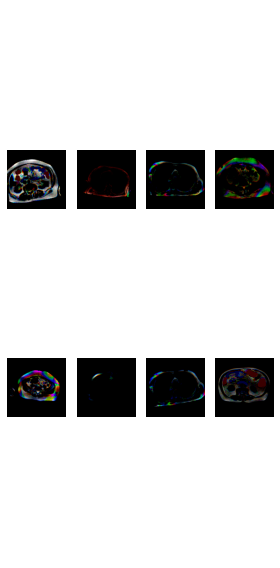

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


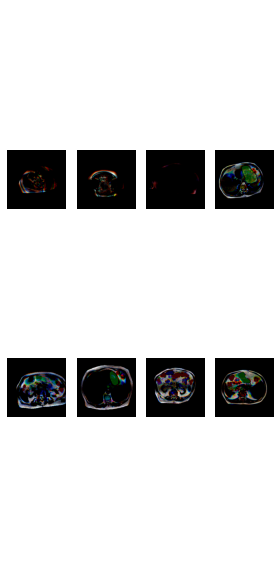

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


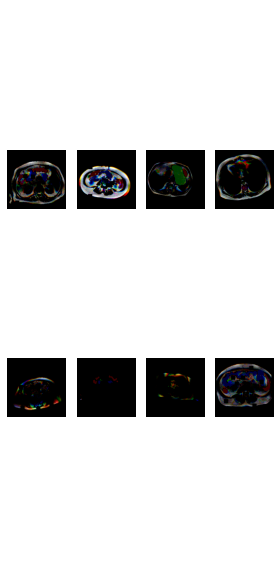

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


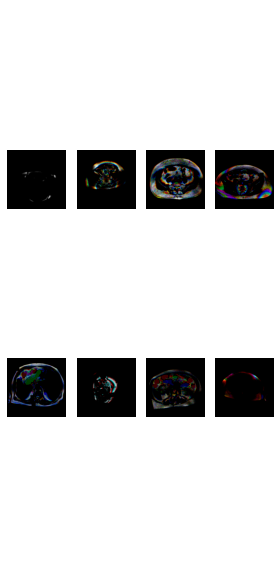

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


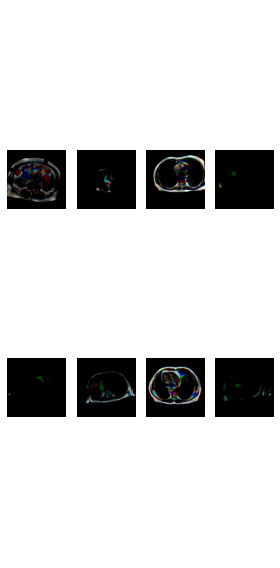

In [24]:
for e in train_ds.skip(10).take(5):
    plot_dataset(e)

In [22]:
lr_sched = SGDRScheduler(min_lr=1e-5,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                         lr_decay=0.85,
                         mult_factor=1.5)

In [26]:
MODEL_NAME = f'resnet_{IMG_SIZE[0]:.0f}'

earlystopping = callbacks.EarlyStopping(monitor='val_loss', verbose=1, min_delta=1e-4, patience=5, mode='min')
plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1, mode='min')
checkpoint = callbacks.ModelCheckpoint(
    f'./checkpoints/{MODEL_NAME}_checkpoint.hdf5',
    monitor="val_loss",
    mode="min",
    verbose=1,
    save_best_only=True)
csv_logger = callbacks.CSVLogger(f'./{MODEL_NAME}_log.out', separator=',')

#callback_list = [earlystopping, plateau, checkpoint, csv_logger]
callback_list = [plateau, checkpoint, csv_logger]

In [27]:
model_history = model.fit(train_ds, epochs=25,
                         steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_ds, callbacks=callback_list)

Epoch 1/25


2022-07-19 17:27:00.474987: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


  23/7968 [..............................] - ETA: 36:49 - loss: 0.7205 - dice_coef: 0.0208 - precision: 0.0086 - recall: 0.4352 - f1-score: 0.0161

KeyboardInterrupt: 

In [41]:
model.save(f'./models/{MODEL_NAME}')

# Inference

Load a model (one pretrained in models) and plot some predictions

In [57]:
DEBUG = True

In [58]:
model = tf.keras.models.load_model(f'models/resnet_224_respath_clahe_adam', compile=False)
model.summary()

Model: "res50v2unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 activation_2 (Activation)      (None, 224, 224, 32  0           ['group_normalization_2[0][0]']  
                                )                                                                 
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 group_normalization_20 (GroupN  (None, 112, 112, 64  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_22 (GroupN  (None, 112, 112, 64  128        ['conv2d_18[0][0]']              
 ormalizat

                                                                                                  
 group_normalization_47 (GroupN  (None, 28, 28, 128)  256        ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_29 (Conv2D)             (None, 56, 56, 64)   4160        ['activation_35[0][0]']          
                                                                                                  
 conv2d_31 (Conv2D)             (None, 56, 56, 64)   36928       ['activation_37[0][0]']          
                                                                                                  
 activation_21 (Activation)     (None, 112, 112, 64  0           ['group_normalization_21[0][0]'] 
                                )                                                                 
          

                                                                                                  
 activation_39 (Activation)     (None, 56, 56, 64)   0           ['add_7[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 64  4160        ['group_normalization_24[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 112, 112, 64  36928       ['group_normalization_24[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_5 (Activation)      (None, 224, 224, 32  0           ['group_normalization_5[0][0]']  
          

 activation_40 (Activation)     (None, 56, 56, 64)   0           ['group_normalization_40[0][0]'] 
                                                                                                  
 activation_42 (Activation)     (None, 56, 56, 64)   0           ['group_normalization_42[0][0]'] 
                                                                                                  
 group_normalization_26 (GroupN  (None, 112, 112, 64  128        ['conv2d_21[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_28 (GroupN  (None, 112, 112, 64  128        ['conv2d_23[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 add_1 (Ad

                                                                                                  
 activation_10 (Activation)     (None, 224, 224, 32  0           ['group_normalization_10[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_12 (Activation)     (None, 224, 224, 32  0           ['group_normalization_12[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_52 (Activation)     (None, 56, 56, 256)  0           ['group_normalization_52[0][0]'] 
                                                                                                  
 group_normalization_44 (GroupN  (None, 56, 56, 64)  128         ['activation_44[0][0]']          
 ormalizat

 ormalization)                  )                                                                 
                                                                                                  
 group_normalization_54 (GroupN  (None, 112, 112, 12  256        ['conv2d_transpose_2[0][0]']     
 ormalization)                  8)                                                                
                                                                                                  
 activation_34 (Activation)     (None, 112, 112, 64  0           ['add_6[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 224, 224, 32  1056        ['group_normalization_14[0][0]'] 
                                )                                                                 
          

 conv2d_43 (Conv2D)             (None, 224, 224, 64  55360       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 group_normalization_57 (GroupN  (None, 224, 224, 64  128        ['conv2d_43[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_57 (Activation)     (None, 224, 224, 64  0           ['group_normalization_57[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 224, 224, 3)  195         ['activation_57[0][0]']          
          

In [53]:
def test_ds_fixup(images, size=None):
    """
    fixes shape for input to neural net
    """
    return tf.image.resize_with_pad(images, IMG_SIZE[0], IMG_SIZE[1], method='nearest'), size

def inverse_test_fixup(image, size):
    """you need to reverse the padding done in the initial resizing. we do this by preserving aspect ratio"""
    height = size[0]
    width = size[1]
    
    if height == width:
        return tf.image.resize_with_pad(image, height, width, method='nearest')
    
    else:
        """
        trained tiles are always square.. so img_height = width
        """
        aspect_ratio = width/height
        img_height = image.shape[1]
        cropped_img = tf.image.resize_with_crop_or_pad(image, int(img_height/aspect_ratio), img_height)
        
        return tf.image.resize_with_pad(cropped_img, height, width, method='nearest')
    
def resnet_preprocess(images, labels):
    
    img = tf.clip_by_value(images, 0., 1.)
    img *= 255.
    
    return tf.keras.applications.resnet_v2.preprocess_input(img), labels

def create_mask_sigmoid(mask, class_probs=[0.5, 0.5, 0.5]):
    class_probs = tf.constant(np.array(class_probs).reshape(1,1,1,3), dtype=tf.float32)
    pred_mask = tf.cast(mask > class_probs, dtype=tf.float32)
    return pred_mask

def debug_str(str_):
    """
    made an error early on putting "nan", convert "nan" to ""
    """
    if str_ == "nan" or pd.isna(str_):
        return ""
    return str_

def plot_dataset_with_pred(elem, model):
    """
    DEBUG ONLY
    input is a (img, mask) tuple with a dimensions of (n, size, 1), (n, size, MASK_CLASS)
    batch size is usually a multiple of 2^N where N > 1, so they are divisible by 4
    """
    img, size = elem
    batch_size = img.shape[0]
    
    num_cols = 1
    num_rows = batch_size
    
    for k in range(num_rows):
        fig = plt.figure(figsize=(4, 4))
        plt.axis(False)

        ax = fig.add_subplot(1, 1, 1)
        ax.imshow(img[k,...], cmap='gray')
        
        img_pred = model.predict(img[k,...][None,...])
        img_mask = tf.squeeze(create_mask_sigmoid(img_pred))
        
        for j in range(len(MASK_CLASS)):
            ax.imshow(np.tile(img_mask[...,j][...,np.newaxis], 4) * MASK_COL[j])

        ax.axis(False)
        plt.tight_layout()
        plt.show()   
    return


def plot_df_with_pred(df, model=None):
    """
    DEBUG ONLY
    input is a (img, mask) tuple with a dimensions of (n, size, 1), (n, size, MASK_CLASS)
    batch size is usually a multiple of 2^N where N > 1, so they are divisible by 4
    """
    CLAHE = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    num_cols = 2
    num_rows = len(df)

    if num_rows > 15:
        print('df too large, not worth printing')
        return

    for k in range(num_rows):
        fig = plt.figure(figsize=(12, 4))
        plt.axis(False)
        
        row = df.iloc[k]
        
        img = np.empty((row['height'], row['width'], 3))
        #img[...] = process_img(row['fn'])

        img[...,0] = tf.squeeze(process_img(row['fn'], clahe=CLAHE))
        img[...,1] = tf.squeeze(process_img(row['fn_1'], clahe=CLAHE))
        img[...,2] = tf.squeeze(process_img(row['fn_2'], clahe=CLAHE))
        
        ax = fig.add_subplot(1, 3, 1)
        ax.imshow(img, cmap='gray')
        
        for idx, i in enumerate(MASK_CLASS):
            tmp_str = debug_str(row[i])
            ax.imshow(np.tile(rle_decode(tmp_str, (row['height'], row['width']))[...,np.newaxis], 4) * MASK_COL[idx])
            
        ax.set_title('ground mask')
        ax.axis(False)
              
        if model:
            ax = fig.add_subplot(1, 3, 2)
            img_inp,_ = test_ds_fixup(img)
            
            ax.imshow(tf.squeeze(inverse_test_fixup(img_inp, (row['height'], row['width']))))
            
            img_inp,_ = resnet_preprocess(img_inp, None)
            img_inp = img_inp[None,...]            
            img_pred = model.predict(img_inp)
            img_mask = create_mask_sigmoid(img_pred)
            img_fix = tf.squeeze(inverse_test_fixup(img_mask, (row['height'], row['width'])))
            
            print(img_fix.shape)
            
            for j in range(len(MASK_CLASS)):
                ax.imshow(np.tile(img_fix[...,j][...,np.newaxis], 4) * MASK_COL[j])
            
            ax.set_title('pred')
            ax.axis(False)
            
            ax = fig.add_subplot(1, 3, 3)
            
            for idx, i in enumerate(MASK_CLASS):
                tmp_str = debug_str(row[i])
                diff = np.abs(rle_decode(tmp_str, (row['height'], row['width'])) - img_fix[..., idx])
                ax.imshow(np.tile(diff[...,np.newaxis], 4) * MASK_COL[idx])
            
            ax.set_title('diff')
            ax.axis(False)
            
        plt.tight_layout()
        #plt.savefig('test.png')
        plt.show()
        
    return

In [43]:
"""
need to first glob out all data in test folder -> retrieve relevant info
create a DF that we can run our inference script over
take results of inference -> RLE it
format back into our submission script
"""

#Set to False before submitting model

test_df = pd.read_csv(f"{PATH_DIR}/sample_submission.csv")
test_fp = glob.glob(f'{PATH_DIR}/test/**/*.png', recursive=True)

if DEBUG:
    test_df = pd.read_csv(f"{PATH_DIR}/train.csv").iloc[180:234]
    #test_df = test_df.drop(columns=['segmentation'])
    #test_df['predicted'] = ""
    test_fp = glob.glob(f'{PATH_DIR}/train/**/*.png', recursive=True)

if DEBUG:
    test_df = df_preprocessing(test_df, test_fp)
    test_df = df_strided(test_df)
    
else:
    test_df = df_preprocessing(test_df, test_fp, submission=True)
    test_df = df_strided(test_df, submission=True)
    
print(test_df)

                          id  \
0   case123_day20_slice_0061   
1   case123_day20_slice_0062   
2   case123_day20_slice_0063   
3   case123_day20_slice_0064   
4   case123_day20_slice_0065   
5   case123_day20_slice_0066   
6   case123_day20_slice_0067   
7   case123_day20_slice_0068   
8   case123_day20_slice_0069   
9   case123_day20_slice_0070   
10  case123_day20_slice_0071   
11  case123_day20_slice_0072   
12  case123_day20_slice_0073   
13  case123_day20_slice_0074   
14  case123_day20_slice_0075   
15  case123_day20_slice_0076   
16  case123_day20_slice_0077   
17  case123_day20_slice_0078   

                                                   fn  \
0   ..//train/case123/case123_day20/scans/slice_00...   
1   ..//train/case123/case123_day20/scans/slice_00...   
2   ..//train/case123/case123_day20/scans/slice_00...   
3   ..//train/case123/case123_day20/scans/slice_00...   
4   ..//train/case123/case123_day20/scans/slice_00...   
5   ..//train/case123/case123_day20/scans/slice_0

1/1 [==============================] - 0s 25ms/step
(266, 266, 3)


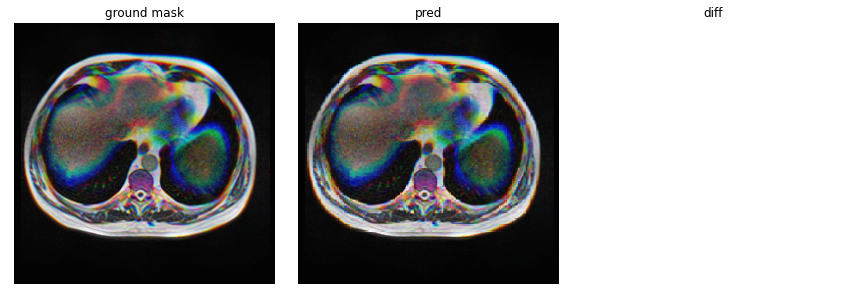

1/1 [==============================] - 0s 25ms/step
(266, 266, 3)


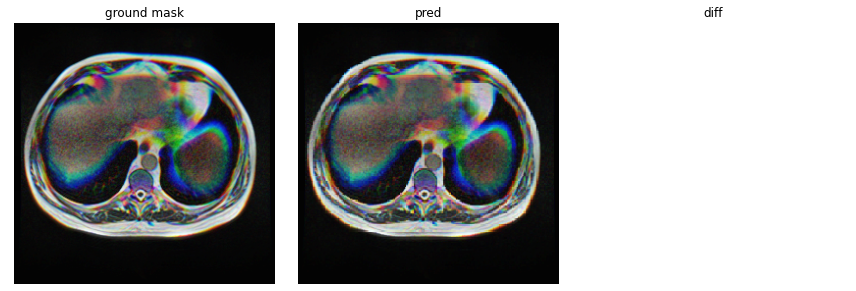

1/1 [==============================] - 0s 25ms/step
(266, 266, 3)


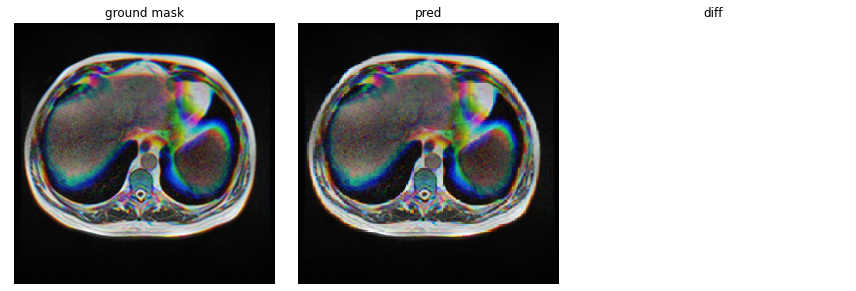

1/1 [==============================] - 0s 24ms/step
(266, 266, 3)


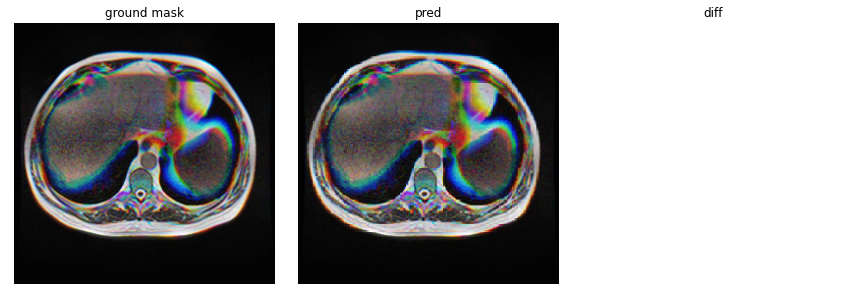

1/1 [==============================] - 0s 29ms/step
(266, 266, 3)


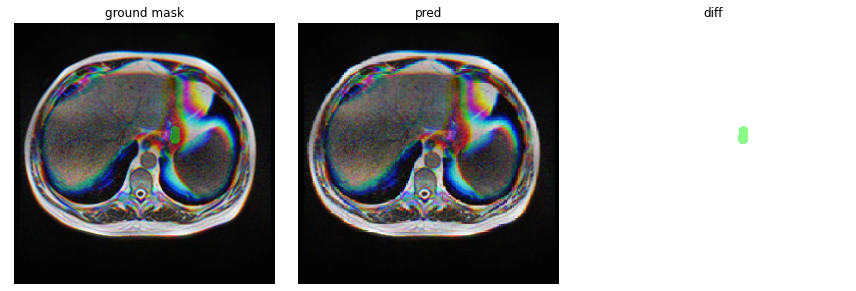

1/1 [==============================] - 0s 27ms/step
(266, 266, 3)


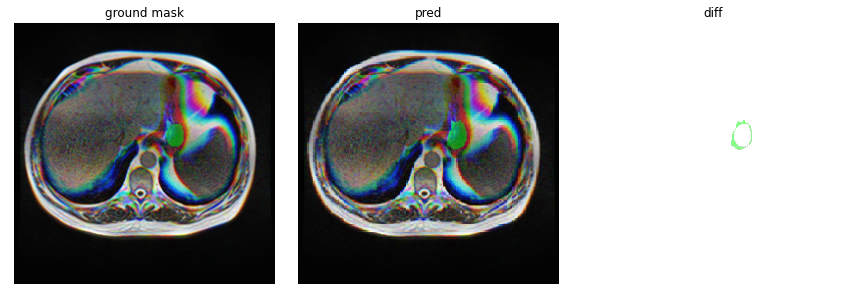

1/1 [==============================] - 0s 22ms/step
(266, 266, 3)


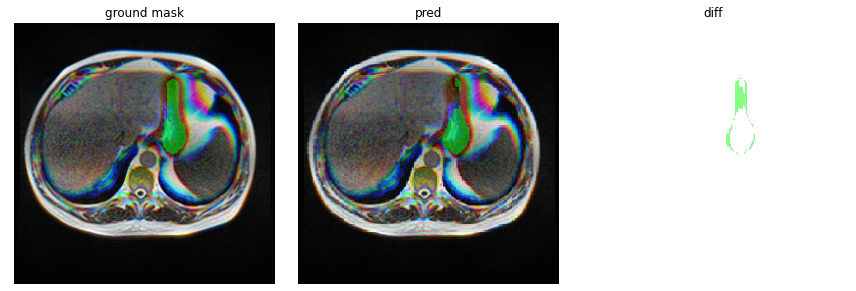

1/1 [==============================] - 0s 26ms/step
(266, 266, 3)


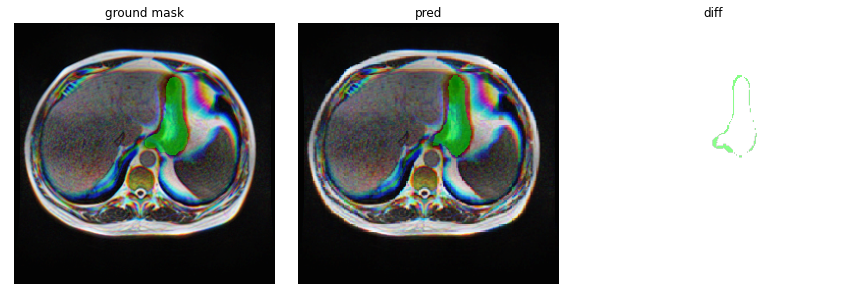

1/1 [==============================] - 0s 27ms/step
(266, 266, 3)


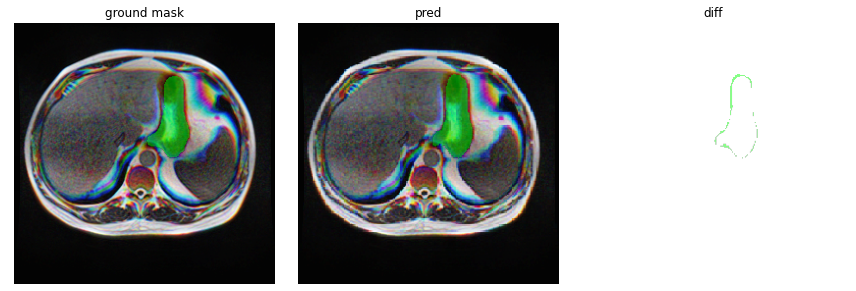

1/1 [==============================] - 0s 26ms/step
(266, 266, 3)


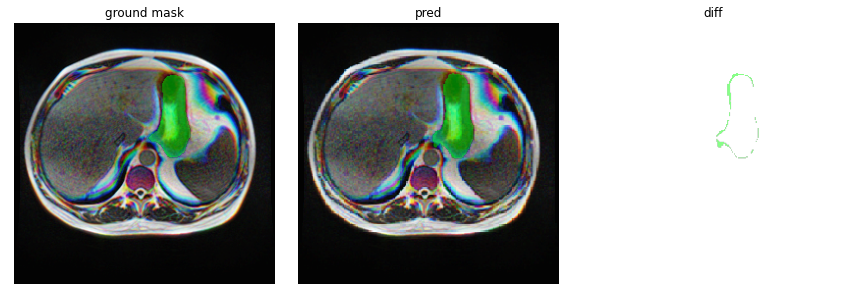

In [54]:
if DEBUG:
    plot_df_with_pred(test_df.iloc[:10], model=model)

In [48]:
def df_infer_parser(row):
    """
    simply read in fn, then process image.
    """  
    CLAHE = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = np.empty((row['height'], row['width'], 3))

    img[...,0] = tf.squeeze(process_img(row['fn'], clahe=CLAHE))
    img[...,1] = tf.squeeze(process_img(row['fn_1'], clahe=CLAHE))
    img[...,2] = tf.squeeze(process_img(row['fn_2'], clahe=CLAHE))

    return img

In [49]:
if DEBUG:
    sub_df = pd.read_csv(f"{PATH_DIR}/train.csv")
    del sub_df['segmentation']
    
else:
    sub_df = pd.read_csv(f"{PATH_DIR}/sample_submission.csv")
    del sub_df['predicted']
    
pred_id = []
pred_class = []
pred_enc = []

for idx, elem in enumerate(test_df.iterrows()):
    row = elem[1]
    img = df_infer_parser(row)
    img_inp, _ = test_ds_fixup(img)
    img_inp, _ = resnet_preprocess(img_inp, None)
    
    img_inp = tf.expand_dims(img_inp, axis=0)
    
    model_pred = model.predict(img_inp)
    model_mask = create_mask_sigmoid(model_pred)
    model_mask_og = inverse_test_fixup(model_mask, [row['height'], row['width']])
    
    for i in range(3):
        pred_id.append(row['id'])
        pred_class.append(MASK_CLASS[i])
        pred_enc.append(rle_encode(model_mask_og[0,...,i].numpy()))

pred_df = pd.DataFrame({"id": pred_id, "class":pred_class, "predicted":pred_enc})

1/1 [==============================] - 0s 27ms/step


In [50]:
if len(sub_df) > 0:
    sub_df = sub_df.merge(pred_df, on=['id', 'class'])
    
display(sub_df)

id        class  \
0   case123_day20_slice_0061  large_bowel   
1   case123_day20_slice_0061  small_bowel   
2   case123_day20_slice_0061      stomach   
3   case123_day20_slice_0062  large_bowel   
4   case123_day20_slice_0062  small_bowel   
5   case123_day20_slice_0062      stomach   
6   case123_day20_slice_0063  large_bowel   
7   case123_day20_slice_0063  small_bowel   
8   case123_day20_slice_0063      stomach   
9   case123_day20_slice_0064  large_bowel   
10  case123_day20_slice_0064  small_bowel   
11  case123_day20_slice_0064      stomach   
12  case123_day20_slice_0065  large_bowel   
13  case123_day20_slice_0065  small_bowel   
14  case123_day20_slice_0065      stomach   
15  case123_day20_slice_0066  large_bowel   
16  case123_day20_slice_0066  small_bowel   
17  case123_day20_slice_0066      stomach   
18  case123_day20_slice_0067  large_bowel   
19  case123_day20_slice_0067  small_bowel   
20  case123_day20_slice_0067      stomach   
21  case123_day20_slice_0068  large_bowel   
22  case123_day20_slice_0068  small_bowel   
23  case123_day20_slice_0068      stomach   
24  case123_day20_slice_0069  large_bowel   
25  case123_day20_slice_0069  small_bowel   
26  case123_day20_slice_0069      stomach   
27  case123_day20_slice_0070  large_bowel   
28  case123_day20_slice_0070  small_bowel   
29  case123_day20_slice_0070      stomach   
30  case123_day20_slice_0071  large_bowel   
31  case123_day20_slice_0071  small_bowel   
32  case123_day20_slice_0071      stomach   
33  case123_day20_slice_0072  large_bowel   
34  case123_day20_slice_0072  small_bowel   
35  case123_day20_slice_0072      stomach   
36  case123_day20_slice_0073  large_bowel   
37  case123_day20_slice_0073  small_bowel   
38  case123_day20_slice_0073      stomach   
39  case123_day20_slice_0074  large_bowel   
40  case123_day20_slice_0074  small_bowel   
41  case123_day20_slice_0074      stomach   
42  case123_day20_slice_0075  large_bowel   
43  case123_day20_slice_0075  small_bowel   
44  case123_day20_slice_0075      stomach   
45  case123_day20_slice_0076  large_bowel   
46  case123_day20_slice_0076  small_bowel   
47  case123_day20_slice_0076      stomach   
48  case123_day20_slice_0077  large_bowel   
49  case123_day20_slice_0077  small_bowel   
50  case123_day20_slice_0077      stomach   
51  case123_day20_slice_0078  large_bowel   
52  case123_day20_slice_0078  small_bowel   
53  case123_day20_slice_0078      stomach   

                                            predicted  
0                                                      
1                                                      
2                                                      
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8                                                      
9                                                      
10                                                     
11                                                     
12                                                     
13                                                     
14                                                     
15                                                     
16                                                     
17  26499 2 26760 1 26765 2 27025 9 27291 11 27556...  
18                                                     
19                                                     
20  15057 3 15323 4 15589 5 15855 6 16121 6 16387 ...  
21                                                     
22                                                     
23  14257 5 14523 5 14788 8 15053 10 15319 11 1558...  
24                                                     
25                                                     
26  13991 3 14255 10 14521 10 14785 13